In [2]:

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Generating Dataset

path_root = "C:/Users/Max/Documents/thesis_data"

batches = ImageDataGenerator().flow_from_directory(directory=path_root, color_mode = "rgb", 
                                                   target_size=(128,128), batch_size = 40000)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [5]:
batches.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9,
 'benign': 10}

In [6]:
imgs.shape

(26548, 128, 128, 3)

In [7]:
labels.shape

(26548, 11)

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

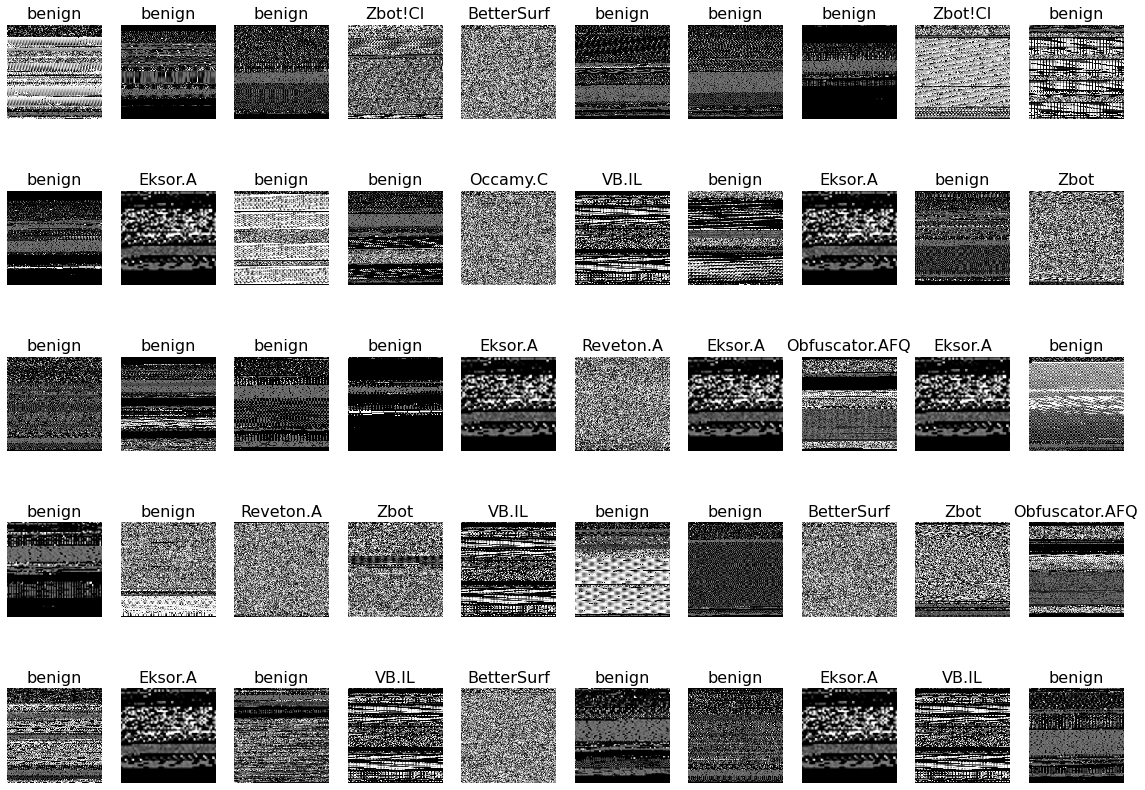

In [9]:
plots(imgs, titles = labels)

In [1]:
classes = batches.class_indices.keys()

NameError: name 'batches' is not defined

In [134]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 11 artists>

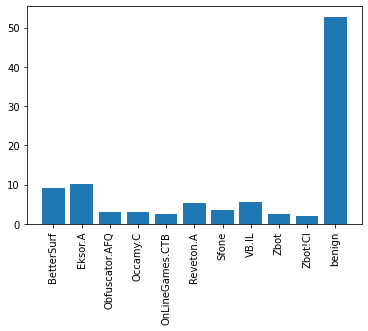

In [135]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

# Train and Test

In [136]:
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [137]:
X_train.shape

(18583, 128, 128, 1)

In [138]:
X_test.shape

(7965, 128, 128, 1)

In [139]:
y_train.shape

(18583, 11)

In [140]:
y_test.shape

(7965, 11)

# Convolutional Neural Network

We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 128 * 128 * 3

In [141]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

We want **11** classes

In [283]:
num_classes = 11
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  11


Building the model

In [147]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(128,128,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [148]:
Malware_model = malware_model()

In [149]:
Malware_model.summary() # Overview of the CNN model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 30)      300       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 30)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 15)        4065      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 15)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 15)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 13500)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [150]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10) # The actual computation of the CNN

Epoch 1/10
581/581 [==============================] - 11s 17ms/step - loss: 0.8698 - accuracy: 0.7577 - val_loss: 0.2805 - val_accuracy: 0.9101
Epoch 2/10
581/581 [==============================] - 8s 14ms/step - loss: 0.3311 - accuracy: 0.8935 - val_loss: 0.2414 - val_accuracy: 0.9184
Epoch 3/10
581/581 [==============================] - 8s 13ms/step - loss: 0.2581 - accuracy: 0.9161 - val_loss: 0.2076 - val_accuracy: 0.9267
Epoch 4/10
581/581 [==============================] - 8s 14ms/step - loss: 0.2197 - accuracy: 0.9272 - val_loss: 0.1900 - val_accuracy: 0.9421
Epoch 5/10
581/581 [==============================] - 8s 14ms/step - loss: 0.1996 - accuracy: 0.9343 - val_loss: 0.1683 - val_accuracy: 0.9443
Epoch 6/10
581/581 [==============================] - 8s 14ms/step - loss: 0.1774 - accuracy: 0.9389 - val_loss: 0.1669 - val_accuracy: 0.9465
Epoch 7/10
581/581 [==============================] - 8s 14ms/step - loss: 0.1558 - accuracy: 0.9478 - val_loss: 0.1593 - val_accuracy: 0.951

In [151]:
scores = Malware_model.evaluate(X_test, y_test) # Testing the CNN on the test set

249/249 [==============================] - 1s 5ms/step - loss: 0.1580 - accuracy: 0.9547


In [256]:
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

Overall CNN Accuracy: 0.9546766877174377
(The number of correct predictions divided by the number of total predictions)


# Confusion Matrix
Analysing the results

In [200]:
y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)

In [201]:
y_pred

array([10,  1, 10, ...,  1, 10,  4], dtype=int64)

In [202]:
y_test2 = np.argmax(y_test, axis=1)

In [203]:
y_test2

array([10,  1, 10, ...,  1, 10,  4], dtype=int64)

In [157]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [158]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

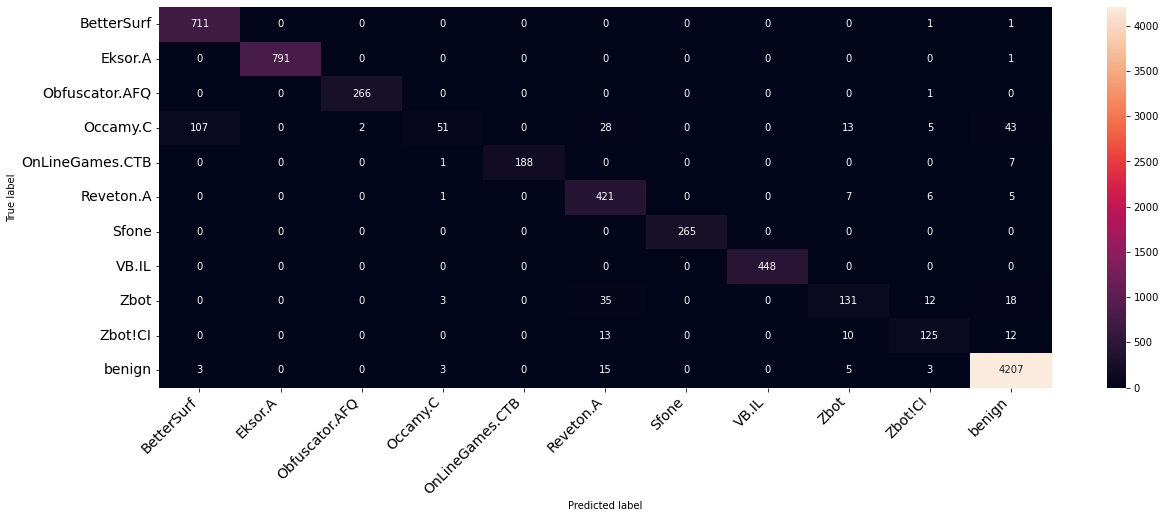

In [159]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

# Detection Measurement
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

In [268]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [232]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue


In [233]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [242]:
def confusion_matrix_bin(confusion_matrix, class_names, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

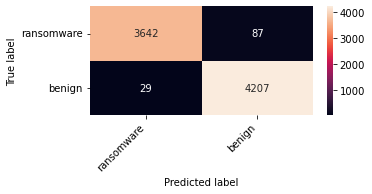

In [246]:
class_names_bin= ("ransomware", "benign")
confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [263]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [264]:
ACC = accuracy_score(y_testbin, y_predbin) # Accuracy

**F1 Score**

In [265]:
F1 = f1_score(y_testbin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [266]:
MCC = matthews_corrcoef(y_testbin, y_predbin) # Matthews Correlation Coefficient

**Show Performance of CNN**

In [282]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of CNN"
print(t)

+------------------------------------------------+
|               Performance of CNN               |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.9767      |
| Accuracy                         | 0.9854      |
| F1 Score                         | 0.9864      |
| Matthews Correlation Coefficient | 0.9708      |
+----------------------------------+-------------+
